X Ur size: (612, 64, 64, 3)
X Ur size: (612, 64, 64, 3)
Y size: (612, 64, 64, 1)
Training examples:    299
Validation examples:  129
Testing examples:     184
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputUr (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
InputUi (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
E1Ur (Conv2D)                   (None, 32, 32, 64)   4864        InputUr[0][0]                    
__________________________________________________________________________________________________
E1Ui (Conv2D)                   (None, 32, 32, 64

299/299 [==============================] - 15s 49ms/step - loss: 0.0025
Epoch 45/100
299/299 [==============================] - 15s 50ms/step - loss: 0.0025
Epoch 46/100
299/299 [==============================] - 15s 49ms/step - loss: 0.0024
Epoch 47/100
299/299 [==============================] - 15s 51ms/step - loss: 0.0028
Epoch 48/100
299/299 [==============================] - 15s 51ms/step - loss: 0.0028
Epoch 49/100
299/299 [==============================] - 15s 50ms/step - loss: 0.0024
Epoch 50/100
299/299 [==============================] - 16s 52ms/step - loss: 0.0026
Epoch 51/100
299/299 [==============================] - 16s 53ms/step - loss: 0.0023
Epoch 52/100
299/299 [==============================] - 15s 51ms/step - loss: 0.0022
Epoch 53/100
299/299 [==============================] - 15s 51ms/step - loss: 0.0022
Epoch 54/100
299/299 [==============================] - 13s 45ms/step - loss: 0.0024
Epoch 55/100
299/299 [==============================] - 13s 45ms/step - loss: 

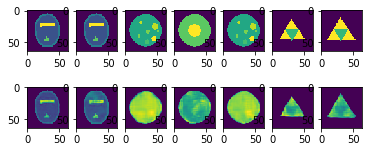

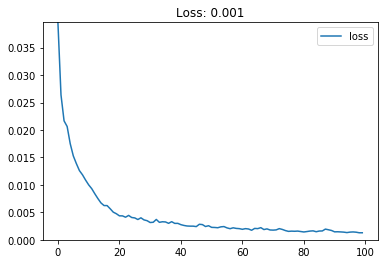

In [17]:

# Basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Keras
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, Lambda, UpSampling2D
from keras.layers import Dot, dot, add

# Others
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#%matplotlib inline 

df=pd.read_msgpack('MREdata_080618.msg')

# Prepare Data
xUr_data = np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
xUi_data = np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)

y_data = np.stack(df.RS.values,axis=2).transpose(2,0,1)
y_data = y_data/10000.

y_data = np.expand_dims(y_data, -1)


print('X Ur size:', xUr_data.shape)
print('X Ur size:', xUi_data.shape)
print('Y size:', y_data.shape)


# Split to Train & Valid
xUr_train, xUr_test, xUi_train, xUi_test,y_train, y_test = train_test_split(xUr_data,xUi_data,y_data,test_size=0.3)

xUr_train, xUr_valid, xUi_train,xUi_valid,y_train, y_valid = train_test_split(xUr_train,xUi_train,y_train,test_size=0.3)

print('Training examples:   ', len(xUr_train))
print('Validation examples: ', len(xUr_valid))
print('Testing examples:    ', len(xUr_test))
#------------------------------------------------

# Encoding
xshp = xUr_train.shape[1:]


xshp = xUr_train.shape[1:]
# Architecture
L1 = 64
L2 = 50
L3 = 32
L4 = 32


x_Ur = Input(shape=xshp,name='InputUr')
x_Ui = Input(shape=xshp,name='InputUi')


hUr  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1Ur')(x_Ur)
hUr  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2Ur')(hUr)
hUr  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3Ur')(hUr)
e_Ur = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4Ur')(hUr)


hUi  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1Ui')(x_Ui)
hUi  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2Ui')(hUi)
hUi  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3Ui')(hUi)
e_Ui = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4Ui')(hUi)

#Combining the two inputs
e= keras.layers.concatenate([e_Ur, e_Ui])

#One final Convolutional layer before decoding.
e= Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4')(e)


# Decoding
h  = Conv2D(L4,kernel_size=(2,2),activation='relu',padding='same',name='D1')(e)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L3,kernel_size=(3,3),activation='relu',padding='same',name='D2')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L2,kernel_size=(3,3),activation='relu',padding='same',name='D3')(h)
h  = UpSampling2D((2,2))(h)
y = Conv2D(1,kernel_size=(5,5),activation='relu',padding='same',name='D4')(h)


model = Model(inputs=[x_Ur,x_Ui],outputs=[y])
model.summary()

model.compile(loss='mse',  optimizer='adam')

nepoch=100
nbatch=10
# Train Model
log = model.fit([xUr_train,xUi_train],[y_train],epochs=nepoch,batch_size=nbatch)

y_pred = model.predict([xUr_test,xUi_test])

y_pred=np.squeeze(y_pred)
y_test=np.squeeze(y_test)
# Visualize Examples
nimg=7
for i in range(nimg):
    ax=plt.subplot(3,nimg,i+1)
    plt.imshow(y_test[i+10])
    ax=plt.subplot(3,nimg,i+1+nimg)
    plt.imshow(y_pred[i+10]) 
    

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    


plot_loss(log)

#### Testing on a Contrast Detail Phantom: (Non-Simulated Data)

In [18]:
df_test=pd.read_msgpack('Test_CDPhantom.msg')

xUr_datatest = np.stack(df_test.Ur.values,axis=3).transpose(3,0,1,2)
xUi_datatest = np.stack(df_test.Ui.values,axis=3).transpose(3,0,1,2)
y_datatest = np.stack(df_test.RS.values,axis=2).transpose(2,0,1)

y_datatest_pred = model.predict([xUr_datatest,xUi_datatest])


print('Dataset Pred Shape:',y_datatest_pred.shape)
print('Dataset Shape:',y_datatest.shape)


y_datatest_pred=np.squeeze(y_datatest_pred)
    
print('Dataset Pred Shape 2:',y_datatest_pred.shape)



Dataset Pred Shape: (43, 64, 64, 1)
Dataset Shape: (43, 64, 64)
Dataset Pred Shape 2: (43, 64, 64)


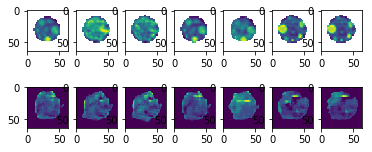

In [19]:
nimg=7
for i in range(nimg):
    ax=plt.subplot(3,nimg,i+1)
    plt.imshow(y_datatest[i+10])
    ax=plt.subplot(3,nimg,i+1+nimg)
    plt.imshow(y_datatest_pred[i+10]) 
    
